<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/ResNet(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, ReLU, Add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Step 1: Libraries imported successfully!")


Step 1: Libraries imported successfully!


In [16]:


# Step 2: Load and preprocess data
print("\nStep 2: Loading data...")

# Load CSV files
train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display basic info about the data
print(f"\nDataset columns: {train_df.columns.tolist()}")
print(f"Production range in training: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")



Step 2: Loading data...
Train data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)

Dataset columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'District_Faridpur', 'District_Feni', 'District_Gaibandha

In [17]:


# Step 3: Create 3-class quantile-based labels
print("\nStep 3: Creating 3-class quantile-based labels...")

# Calculate quantiles based on training data (33.33% and 66.67% for 3 classes)
production_col = 'Production (M.Ton)'
quantiles = train_df[production_col].quantile([0.3333, 0.6667]).values

print(f"Quantile thresholds:")
print(f"  Low/Medium boundary: {quantiles[0]:.4f}")
print(f"  Medium/High boundary: {quantiles[1]:.4f}")

def assign_labels(production_values, quantiles):
    labels = []
    for val in production_values:
        if val <= quantiles[0]:
            labels.append(0)  # Low
        elif val <= quantiles[1]:
            labels.append(1)  # Medium
        else:
            labels.append(2)  # High
    return np.array(labels)

# Create labels for all datasets
y_train = assign_labels(train_df[production_col], quantiles)
y_val = assign_labels(val_df[production_col], quantiles)
y_test = assign_labels(test_df[production_col], quantiles)

# Print label distribution
label_names = ['Low', 'Medium', 'High']
print(f"\nLabel distribution:")
print(f"{'Class':<10} {'Train':<8} {'Val':<8} {'Test':<8}")
print("-" * 35)
for i, name in enumerate(label_names):
    train_count = np.sum(y_train == i)
    val_count = np.sum(y_val == i)
    test_count = np.sum(y_test == i)
    print(f"{name:<10} {train_count:<8} {val_count:<8} {test_count:<8}")



Step 3: Creating 3-class quantile-based labels...
Quantile thresholds:
  Low/Medium boundary: 1093.5353
  Medium/High boundary: 4009.7882

Label distribution:
Class      Train    Val      Test    
-----------------------------------
Low        1314     281      279     
Medium     1314     290      272     
High       1314     274      294     


In [18]:


# Step 4: Prepare features
print("\nStep 4: Preparing features...")

# Drop the target column
feature_cols = [col for col in train_df.columns if col != 'Production (M.Ton)']

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

print(f"Number of features: {len(feature_cols)}")

# Handle missing values
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
X_test = np.nan_to_num(X_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Feature matrix shapes:")
print(f"  X_train: {X_train_scaled.shape}")
print(f"  X_val: {X_val_scaled.shape}")
print(f"  X_test: {X_test_scaled.shape}")




Step 4: Preparing features...
Number of features: 83
Feature matrix shapes:
  X_train: (3942, 83)
  X_val: (845, 83)
  X_test: (845, 83)


In [19]:

# Step 5: Build ResNet model
def residual_block(x, units, dropout_rate=0.2):
    """Create a residual block"""
    # Save input for skip connection
    shortcut = x

    # First layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    # Second layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != units:
        shortcut = Dense(units)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    return x

print(f"\nStep 5: Building ResNet model for 3-class classification...")

# Input layer
inputs = Input(shape=(X_train_scaled.shape[1],))

# Initial dense layer
x = Dense(256)(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Residual blocks with different sizes
x = residual_block(x, 512, 0.3)
x = residual_block(x, 512, 0.3)
x = residual_block(x, 256, 0.25)
x = residual_block(x, 256, 0.25)
x = residual_block(x, 128, 0.2)
x = residual_block(x, 128, 0.2)

# Final dense layers
x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

# Output layer
outputs = Dense(3, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()



Step 5: Building ResNet model for 3-class classification...
Model architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     21,504 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ re_lu_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │    131,584 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 512)       │          0 │ re_lu_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │    262,656 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 512)       │    131,584 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 512)       │          0 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 512)       │          0 │ re_lu_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │    262,656 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_23[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 512)       │          0 │ re_lu_18[0][0]  

 Total params: 1,677,763 (6.40 MB)

 Trainable params: 1,668,099 (6.36 MB)

 Non-trainable params: 9,664 (37.75 KB)

In [20]:


# Step 6: Train the model
epochs = 100
print(f"\nStep 6: Training model for {epochs} epochs...")

# Convert labels to categorical
y_train_cat = to_categorical(y_train, 3)
y_val_cat = to_categorical(y_val, 3)

print(f"Training labels shape: {y_train_cat.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Train model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=epochs,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"Training completed! Total epochs: {len(history.history['loss'])}")




Step 6: Training model for 100 epochs...
Training labels shape: (3942, 3)
Validation labels shape: (845, 3)
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.3391 - loss: 1.2804 - val_accuracy: 0.3621 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3670 - loss: 1.1398 - val_accuracy: 0.5065 - val_loss: 0.9541 - learning_rate: 0.0010
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4675 - loss: 1.0231 - val_accuracy: 0.5432 - val_loss: 0.8941 - learning_rate: 0.0010
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5613 - loss: 0.9123 - val_accuracy: 0.5917 - val_loss: 0.9032 - learning_rate: 0.0010
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6138 - loss: 0.8121 - val_accuracy: 0.6615 - val_loss: 0.8028 - learning_rate: 0.0010
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6874 - loss: 0.7245 - val_accuracy: 0.6793 - val_los

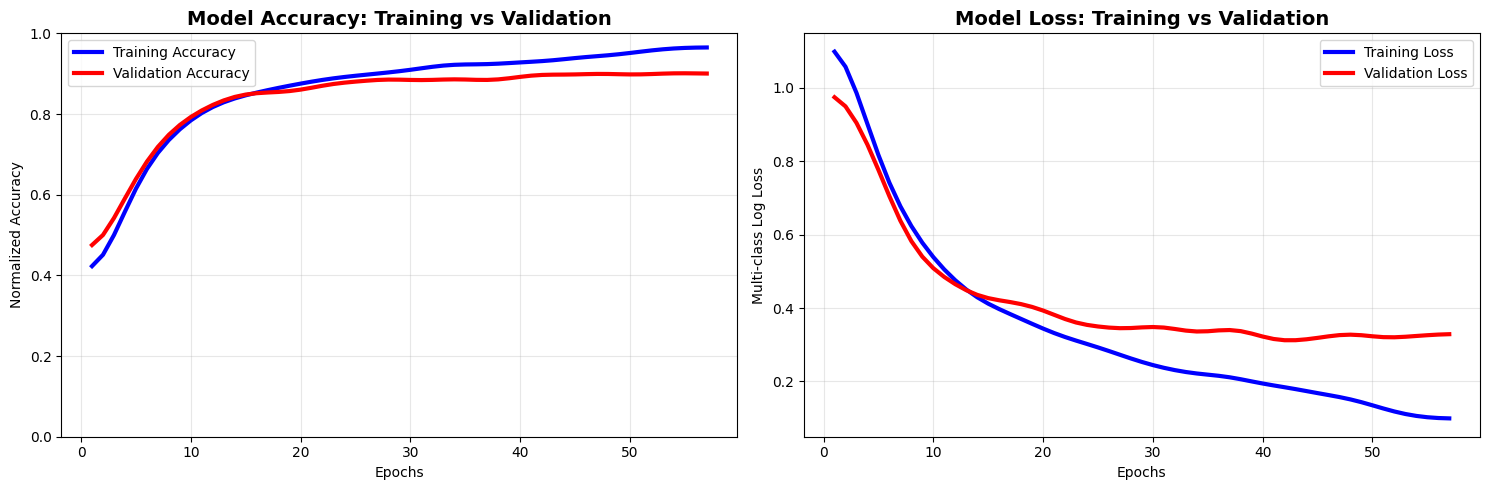


Final Training Metrics:
  Training Accuracy: 0.9650
  Training Loss: 0.0963
  Validation Accuracy: 0.8959
  Validation Loss: 0.3396


In [21]:

# Step 7: Plot smooth training history
def plot_smooth_training_history(history, sigma=2):
    """Plot smooth training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Apply Gaussian smoothing to all curves
    train_acc_smooth = gaussian_filter1d(history.history['accuracy'], sigma=sigma)
    val_acc_smooth = gaussian_filter1d(history.history['val_accuracy'], sigma=sigma)
    train_loss_smooth = gaussian_filter1d(history.history['loss'], sigma=sigma)
    val_loss_smooth = gaussian_filter1d(history.history['val_loss'], sigma=sigma)

    # Plot smooth accuracy
    ax1.plot(epochs, train_acc_smooth, 'b-', label='Training Accuracy', linewidth=3)
    ax1.plot(epochs, val_acc_smooth, 'r-', label='Validation Accuracy', linewidth=3)
    ax1.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Normalized Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot smooth loss
    ax2.plot(epochs, train_loss_smooth, 'b-', label='Training Loss', linewidth=3)
    ax2.plot(epochs, val_loss_smooth, 'r-', label='Validation Loss', linewidth=3)
    ax2.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Multi-class Log Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"\nFinal Training Metrics:")
    print(f"  Training Accuracy: {final_train_acc:.4f}")
    print(f"  Training Loss: {final_train_loss:.4f}")
    print(f"  Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Validation Loss: {final_val_loss:.4f}")

plot_smooth_training_history(history)


In [22]:


# Step 8: Define evaluation functions
def calculate_metrics(y_true, y_pred):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'Accuracy': accuracy,
        'Precision (Weighted)': precision_weighted,
        'Precision (Macro)': precision_macro,
        'Recall (Weighted)': recall_weighted,
        'Recall (Macro)': recall_macro,
        'F1 Score (Weighted)': f1_weighted,
        'F1 Score (Macro)': f1_macro
    }

def plot_confusion_matrix(y_true, y_pred, title, dataset_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Low', 'Medium', 'High']

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(f'{title} - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return cm



Step 9: Evaluating model...

VALIDATION SET RESULTS
Accuracy                 : 0.9089
Precision (Weighted)     : 0.9104
Precision (Macro)        : 0.9109
Recall (Weighted)        : 0.9089
Recall (Macro)           : 0.9091
F1 Score (Weighted)      : 0.9094
F1 Score (Macro)         : 0.9098


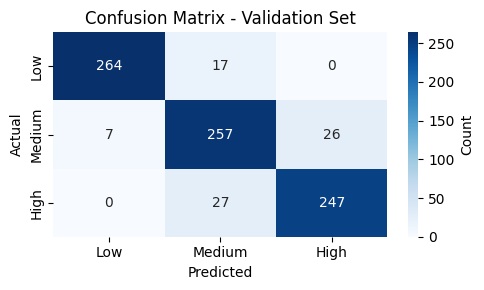


Detailed Classification Report - Validation Set:
--------------------------------------------------
              precision    recall  f1-score   support

         Low     0.9742    0.9395    0.9565       281
      Medium     0.8538    0.8862    0.8697       290
        High     0.9048    0.9015    0.9031       274

    accuracy                         0.9089       845
   macro avg     0.9109    0.9091    0.9098       845
weighted avg     0.9104    0.9089    0.9094       845


TEST SET RESULTS
Accuracy                 : 0.9183
Precision (Weighted)     : 0.9217
Precision (Macro)        : 0.9206
Recall (Weighted)        : 0.9183
Recall (Macro)           : 0.9185
F1 Score (Weighted)      : 0.9192
F1 Score (Macro)         : 0.9187


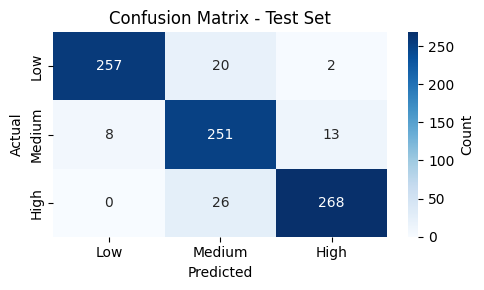


Detailed Classification Report - Test Set:
--------------------------------------------------
              precision    recall  f1-score   support

         Low     0.9698    0.9211    0.9449       279
      Medium     0.8451    0.9228    0.8822       272
        High     0.9470    0.9116    0.9289       294

    accuracy                         0.9183       845
   macro avg     0.9206    0.9185    0.9187       845
weighted avg     0.9217    0.9183    0.9192       845



In [23]:


# Step 9: Evaluate model on validation and test sets
print("\nStep 9: Evaluating model...")

# Make predictions
y_val_pred = np.argmax(model.predict(X_val_scaled, verbose=0), axis=1)
y_test_pred = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)

datasets = [(y_val, y_val_pred, 'Validation'), (y_test, y_test_pred, 'Test')]
results = {}

for y_true, y_pred, name in datasets:
    print(f"\n{'='*60}")
    print(f"{name.upper()} SET RESULTS")
    print('='*60)

    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)
    results[name] = metrics

    # Display metrics
    for metric, value in metrics.items():
        print(f"{metric:<25}: {value:.4f}")

    # Plot confusion matrix
    cm = plot_confusion_matrix(y_true, y_pred, "Confusion Matrix", f"{name} Set")

    # Print detailed classification report
    print(f"\nDetailed Classification Report - {name} Set:")
    print("-" * 50)
    labels = ['Low', 'Medium', 'High']
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))


In [24]:

# Step 10: Final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Model Architecture: ResNet with {len(feature_cols)} input features")
print(f"Classes: 3 (Low, Medium, High)")
print(f"Training completed in {len(history.history['loss'])} epochs")
print(f"\nKey Performance Metrics:")
print(f"{'Dataset':<12} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<12}")
print("-" * 45)
for dataset, metrics in results.items():
    acc = metrics['Accuracy']
    macro_f1 = metrics['F1 Score (Macro)']
    weighted_f1 = metrics['F1 Score (Weighted)']
    print(f"{dataset:<12} {acc:<10.4f} {macro_f1:<10.4f} {weighted_f1:<12.4f}")

print(f"\nQuantile Boundaries:")
print(f"  Low ≤ {quantiles[0]:.4f} < Medium ≤ {quantiles[1]:.4f} < High")

print("\n🎉 Pipeline completed successfully!")
print("\nWhat was accomplished:")
print("✅ Loaded and preprocessed 3 CSV files")
print("✅ Created 3-class quantile-based labels (Low, Medium, High)")
print("✅ Built and trained ResNet model")
print("✅ Generated all requested metrics (Accuracy, Precision, Recall, F1, Macro F1)")
print("✅ Plotted confusion matrices for validation and test sets")
print("✅ Plotted smooth training vs validation accuracy curves")
print("✅ Provided detailed classification reports")



FINAL SUMMARY
Model Architecture: ResNet with 83 input features
Classes: 3 (Low, Medium, High)
Training completed in 57 epochs

Key Performance Metrics:
Dataset      Accuracy   Macro F1   Weighted F1 
---------------------------------------------
Validation   0.9089     0.9098     0.9094      
Test         0.9183     0.9187     0.9192      

Quantile Boundaries:
  Low ≤ 1093.5353 < Medium ≤ 4009.7882 < High

🎉 Pipeline completed successfully!

What was accomplished:
✅ Loaded and preprocessed 3 CSV files
✅ Created 3-class quantile-based labels (Low, Medium, High)
✅ Built and trained ResNet model
✅ Generated all requested metrics (Accuracy, Precision, Recall, F1, Macro F1)
✅ Plotted confusion matrices for validation and test sets
✅ Plotted smooth training vs validation accuracy curves
✅ Provided detailed classification reports
